In [105]:
import os
import zipfile
import urllib.request
import ssl
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

# pyGMs library
import pyGMs as gm
import pyGMs.ising
import pyGMs.wmb

%matplotlib inline


# Download Dataset

In [106]:
dataset_url = "https://files.grouplens.org/datasets/movielens/ml-latest-small.zip"
zip_file = "ml-latest-small.zip"
extract_folder = "ml-latest-small"

# Mac workaround (only if needed)
ssl._create_default_https_context = ssl._create_unverified_context

if not os.path.exists(extract_folder):
    print("Downloading MovieLens dataset...")
    urllib.request.urlretrieve(dataset_url, zip_file)
    print("Extracting...")
    with zipfile.ZipFile(zip_file, 'r') as zip_ref:
        zip_ref.extractall()
    print("Done.")
else:
    print("Dataset already exists.")


Dataset already exists.


In [107]:
ratings = pd.read_csv('ml-latest-small/ratings.csv')

# Filter top users/movies
top_users = ratings['userId'].value_counts().head(2000).index
top_movies = ratings['movieId'].value_counts().head(10).index


filtered = ratings[(ratings['userId'].isin(top_users)) & (ratings['movieId'].isin(top_movies))]
pivot = filtered.pivot(index='userId', columns='movieId', values='rating').fillna(0)

# Binary matrix: 1 if liked (rating ≥ 4), else 0
X = (pivot >= 4).astype(int).to_numpy()


In [108]:
movies = pd.read_csv(os.path.join(extract_folder, 'movies.csv'))
id_to_title = dict(zip(movies['movieId'], movies['title']))

# Build a short label dictionary for visualization
short = {i: id_to_title[mid] for i, mid in enumerate(pivot.columns)}
print(short)


{0: 'Braveheart (1995)', 1: 'Star Wars: Episode IV - A New Hope (1977)', 2: 'Pulp Fiction (1994)', 3: 'Shawshank Redemption, The (1994)', 4: 'Forrest Gump (1994)', 5: 'Jurassic Park (1993)', 6: "Schindler's List (1993)", 7: 'Terminator 2: Judgment Day (1991)', 8: 'Silence of the Lambs, The (1991)', 9: 'Matrix, The (1999)'}


In [109]:
Xtr, Xte = train_test_split(X, test_size=0.2, random_state=42)
nMovies = Xtr.shape[1]


In [110]:
pXi = np.mean(Xtr, axis=0)
model0 = gm.GraphModel([gm.Factor([gm.Var(i, 2)], [1 - pXi[i], pXi[i]]) for i in range(nMovies)])

print("Independent model Train LL:", np.mean([model0.logValue(x) for x in Xtr]))
print("Independent model Test  LL:", np.mean([model0.logValue(x) for x in Xte]))


Independent model Train LL: -6.553501113566468
Independent model Test  LL: -6.511912697892133


In [111]:
from sklearn.linear_model import LogisticRegression

C = 1  # Regularization strength
nbrs, th_ij, th_i = [None] * nMovies, [None] * nMovies, np.zeros((nMovies,))
Xtmp = np.copy(Xtr)

for i in range(nMovies):
    Xtmp[:, i] = 0.
    lr = LogisticRegression(penalty='l1', C=C, solver='liblinear').fit(Xtmp, Xtr[:, i])
    nbrs[i] = np.where(np.abs(lr.coef_) > 1e-6)[1]
    th_ij[i] = lr.coef_[0, nbrs[i]] / 2.
    th_i[i] = lr.intercept_ / 2.
    Xtmp[:, i] = Xtr[:, i]

print("Average connectivity at C =", C, ":", np.mean([len(nn) for nn in nbrs]))


Average connectivity at C = 1 : 8.5


/var/folders/dd/mj_wq35n4yxbxcg8pvwwyrx00000gn/T/ipykernel_29895/1013526215.py:12: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  th_i[i] = lr.intercept_ / 2.
/var/folders/dd/mj_wq35n4yxbxcg8pvwwyrx00000gn/T/ipykernel_29895/1013526215.py:12: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  th_i[i] = lr.intercept_ / 2.
/var/folders/dd/mj_wq35n4yxbxcg8pvwwyrx00000gn/T/ipykernel_29895/1013526215.py:12: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  th_i[i] = lr.intercept_ 

In [112]:
factors = [gm.Factor(gm.Var(i, 2), [-t, t]).exp() for i, t in enumerate(th_i)]
for i in range(nMovies):
    for j, n in enumerate(nbrs[i]):
        scope = [gm.Var(i, 2), gm.Var(int(n), 2)]
        t = th_ij[i][j]
        factors.append(gm.Factor(scope, [[t, -t], [-t, t]]).exp())

model1 = gm.GraphModel(factors)
model1.makeMinimal()


Movie Index to Title Mapping:
----------------------------------------
Movie 0: Braveheart (1995)
Movie 1: Star Wars: Episode IV - A New Hope (1977)
Movie 2: Pulp Fiction (1994)
Movie 3: Shawshank Redemption, The (1994)
Movie 4: Forrest Gump (1994)
Movie 5: Jurassic Park (1993)
Movie 6: Schindler's List (1993)
Movie 7: Terminator 2: Judgment Day (1991)
Movie 8: Silence of the Lambs, The (1991)
Movie 9: Matrix, The (1999)
----------------------------------------


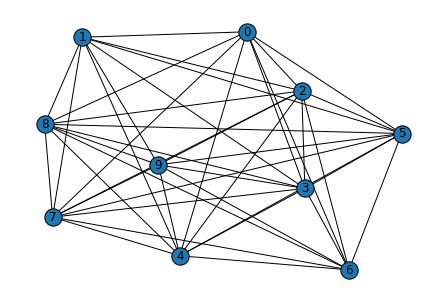

In [113]:
# Print mapping of movie indices to titles
print("Movie Index to Title Mapping:")
print("-" * 40)
for var in model1.vars:
    print(f"Movie {var.label}: {short[var.label]}")
print("-" * 40)

# Draw graph with numeric labels
short_labels = {var.label: var.label for var in model1.vars}
gm.drawMarkovGraph(model1, labels=short_labels)


In [114]:
order, _ = gm.eliminationOrder(model1, 'minfill')
jt = gm.wmb.JTree(model1, elimOrder=order)
lnZ = jt.msgForward()

print("Log partition function:", lnZ)
print("Ising Train LL:", np.mean([model1.logValue(x) for x in Xtr]) - lnZ)
print("Ising Test LL:", np.mean([model1.logValue(x) for x in Xte]) - lnZ)


Log partition function: 23.752228844123756
Ising Train LL: -16.46999607270328
Ising Test LL: -15.773198314931946


In [115]:
def conditional(factor, i, x):
    return factor.t[tuple(x[v] if v != i else slice(v.states) for v in factor.vars)]

def pseudolikelihood(model, X):
    LL = np.zeros(X.shape)
    for i in range(X.shape[1]):  # for each variable (movie)
        flist = model.factorsWith(i, copy=False)
        for j in range(X.shape[0]):  # for each data point (user)
            pXi = 1.
            for f in flist:
                pXi *= conditional(f, i, X[j])
            LL[j, i] = np.log(pXi[X[j, i]] / pXi.sum())
    return LL.sum(1)


In [116]:
print("Pseudo-likelihood (Train):", pseudolikelihood(model1, Xtr).mean())
print("Pseudo-likelihood (Test):", pseudolikelihood(model1, Xte).mean())


Pseudo-likelihood (Train): -10.113411658579016
Pseudo-likelihood (Test): -9.85192751870566
